# Setup

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../../..'))) # access sibling directories

from src.python.metrics import performance_metrics, bootstrapped_metrics
from src.python.helpers import log_with_inf_noise_addition, computation_times
from src.python.visualization import plot_approximations, plot_computation_times

import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Load data

In [3]:
comparison_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data', '02_bridge_sampling_comparison', 'non_nested_models')
bridge_file = '2022_12_02_BF_BS'
NN_fixed_file = '2022_12_06_BF_NN_softmax'

bridge = pd.read_csv(os.path.join(comparison_folder, bridge_file), sep = " ").reset_index(drop=True)
NN_fixed = pd.read_csv(os.path.join(comparison_folder, NN_fixed_file))

results_list = [bridge, NN_fixed]

In [4]:
NN_fixed

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss
0,1,0,0.969890,3.011040e-02,0,3.104519e-02,1090.605605,0.000359,0.210434
1,2,0,0.981640,1.835998e-02,0,1.870337e-02,1090.605605,0.000359,0.210434
2,3,0,1.000000,3.446686e-07,0,3.446688e-07,1090.605605,0.000359,0.210434
3,4,1,0.142598,8.574018e-01,1,6.012711e+00,1090.605605,0.000359,0.210434
4,5,0,0.991528,8.472254e-03,0,8.544647e-03,1090.605605,0.000359,0.210434
...,...,...,...,...,...,...,...,...,...
95,96,0,0.998685,1.314761e-03,0,1.316492e-03,1090.605605,0.000359,0.210434
96,97,0,0.379772,6.202282e-01,1,1.633160e+00,1090.605605,0.000359,0.210434
97,98,1,0.000058,9.999417e-01,1,1.715362e+04,1090.605605,0.000359,0.210434
98,99,1,0.000221,9.997793e-01,1,4.529709e+03,1090.605605,0.000359,0.210434


# Calculate performance metrics

In [5]:
n_bootstrap = 100000
names = ['Bridge sampling', 'Neural network']
metrics = ['Accuracy', 'ROC AUC', 'MAE', 'RMSE', 'Log score', 'Bias']

# Calculate performance metrics
perf_metrics = performance_metrics(results_list, names=names, metrics=metrics)

# Calculate bootstrapped performance metrics
metrics_means, metrics_ses = bootstrapped_metrics(results_list, n_bootstrap=1000, names=names, metrics=metrics)

In [6]:
# Raw results
perf_metrics

,Accuracy,ROC AUC,MAE,RMSE,Log score,Bias
Bridge sampling,0.95,0.9852,0.095463,0.218608,0.154887,-0.006345
Neural network,0.93,0.9796,0.117834,0.242601,0.184791,0.004503


In [7]:
# Bootstrapped means
metrics_means

,Accuracy,ROC AUC,MAE,RMSE,Log score,Bias
Bridge sampling,0.95060,0.985266,0.095426,0.215570,0.15458,-0.006623
Neural network,0.92949,0.979443,0.118061,0.240508,0.18506,0.004575


In [8]:
# Bootstrapped standard errors
metrics_ses

,Accuracy,ROC AUC,MAE,RMSE,Log score,Bias
Bridge sampling,0.021690,0.009057,0.019936,0.034671,0.042497,0.021597
Neural network,0.026722,0.011197,0.021864,0.033378,0.043470,0.024242


In [9]:
# Convert to latex table
metrics_means = metrics_means.round(2).drop('MAE', axis=1) # drop MAE column as results do not add much information
metrics_ses = metrics_ses.round(2).drop('MAE', axis=1) # drop MAE column as results do not add much information

for row in range(metrics_means.shape[0]):
    for col in range(metrics_means.shape[1]):
        metrics_means.iloc[row,col] = f'{metrics_means.iloc[row,col]}' + f' ({metrics_ses.iloc[row,col]})'

print(metrics_means.style.to_latex(position='h', position_float='centering', hrules=True))

\begin{table}[h]
\centering
\begin{tabular}{llllll}
\toprule
 & Accuracy & ROC AUC & RMSE & Log score & Bias \\
\midrule
Bridge sampling & 0.95 (0.02) & 0.99 (0.01) & 0.22 (0.03) & 0.15 (0.04) & -0.01 (0.02) \\
Neural network & 0.93 (0.03) & 0.98 (0.01) & 0.24 (0.03) & 0.19 (0.04) & 0.0 (0.02) \\
\bottomrule
\end{tabular}
\end{table}



In [10]:
# How do the proportions of selected models look like?

print('True proportion = {}'.format(bridge['true_model'].mean()))
print('Bridge Sampling proportion = {}'.format(bridge['selected_model'].mean()))
print('NN proportion = {}'.format(NN_fixed['selected_model'].mean()))

True proportion = 0.5
Bridge Sampling proportion = 0.51
NN proportion = 0.51


# Plot PMPs & log BFs

In [11]:
# Compute Log BFs

log_bridge_bfs = log_with_inf_noise_addition(bridge)
log_NN_fixed_bfs = log_with_inf_noise_addition(NN_fixed)

## BS vs fixed NN

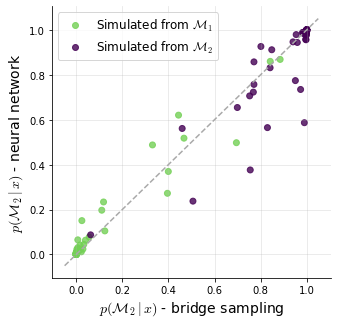

In [12]:
# PMPs
plot_approximations(bridge, NN_fixed, approximated_outcome='PMPs', NN_name='neural network', save=False)

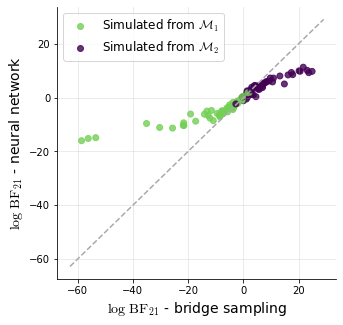

In [13]:
# Log BFs
plot_approximations(bridge, NN_fixed, approximated_outcome='Log BFs', NN_name='neural network')

# of included datasets: 85


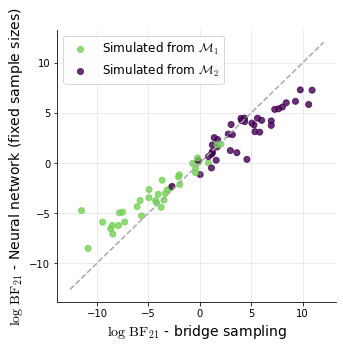

In [14]:
# Log Bfs with filter
filter_high = bridge['bayes_factor']<100000
filter_low = bridge['bayes_factor']>0.00001
bridge_filtered = bridge[filter_high & filter_low].reset_index(drop=True)
NN_fixed_filtered = NN_fixed[filter_high & filter_low].reset_index(drop=True)
print('# of included datasets: {}'.format(min([sum(filter_high), sum(filter_low)])))

plot_approximations(bridge_filtered, NN_fixed_filtered, approximated_outcome='Log BFs', NN_name='Neural network (fixed sample sizes)', save=False)

# Find biggest discrepancies and compare implications

In [15]:
# Find biggest PMP discrepancies
divergence_fixed = np.argmax(abs(bridge["m1_prob"] - NN_fixed["m1_prob"]))

In [16]:
# Look up respective BFs: Bridge vs. fixed network
print(f'BF Bridge sampling: {bridge.loc[divergence_fixed, "bayes_factor"]}')
print(f'BF NN: {NN_fixed.loc[divergence_fixed, "bayes_factor"]}')

BF Bridge sampling: 96.8850569630086
BF NN: 1.4190993487678645


In [17]:
bridge["divergences"] = abs(bridge["m1_prob"] - NN_fixed["m1_prob"])
NN_fixed["divergences"] = abs(bridge["m1_prob"] - NN_fixed["m1_prob"])
bridge.sort_values("divergences", ascending=False)

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,m0_bridge_error,m1_bridge_error,compile_time,stan_time,bridge_time,divergences
20,21,1,1.021606e-02,9.897839e-01,1,9.688506e+01,0%,1%,41.988324,178.812704,52.748515,4.031609e-01
66,67,1,2.450077e-01,7.549923e-01,1,3.081505e+00,0%,1%,41.988324,180.472303,52.836880,3.787467e-01
71,72,1,4.934690e-01,5.065310e-01,1,1.026470e+00,0%,1%,41.988324,143.168328,53.623555,2.691587e-01
31,32,1,1.704504e-01,8.295496e-01,1,4.866809e+00,0%,1%,41.988324,175.021875,52.785549,2.647987e-01
26,27,1,2.663987e-02,9.733601e-01,1,3.653772e+01,0%,1%,41.988324,184.990202,53.571511,2.388397e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
61,62,1,3.789413e-10,1.000000e+00,1,2.638931e+09,0%,2%,41.988324,179.702695,52.948475,1.239739e-05
38,39,0,1.000000e+00,7.516608e-12,0,7.516608e-12,0%,1%,41.988324,230.230717,52.648407,1.215190e-05
2,3,0,1.000000e+00,6.428038e-24,0,6.428038e-24,1%,3%,41.988324,188.762416,53.992873,3.446686e-07
17,18,0,1.000000e+00,4.223497e-25,0,4.223497e-25,0%,2%,41.988324,178.876926,54.210204,2.545590e-07


In [18]:
NN_fixed.sort_values("divergences", ascending=False)

,dataset,true_model,m0_prob,m1_prob,selected_model,bayes_factor,training_time,inference_time,final_epoch_loss,divergences
20,21,1,0.413377,5.866230e-01,1,1.419099e+00,1090.605605,0.000359,0.210434,4.031609e-01
66,67,1,0.623754,3.762456e-01,0,6.031952e-01,1090.605605,0.000359,0.210434,3.787467e-01
71,72,1,0.762628,2.373724e-01,0,3.112559e-01,1090.605605,0.000359,0.210434,2.691587e-01
31,32,1,0.435249,5.647509e-01,1,1.297535e+00,1090.605605,0.000359,0.210434,2.647987e-01
26,27,1,0.265480,7.345204e-01,1,2.766768e+00,1090.605605,0.000359,0.210434,2.388397e-01
...,...,...,...,...,...,...,...,...,...,...
61,62,1,0.000012,9.999876e-01,1,8.065869e+04,1090.605605,0.000359,0.210434,1.239739e-05
38,39,0,0.999988,1.215191e-05,0,1.215206e-05,1090.605605,0.000359,0.210434,1.215190e-05
2,3,0,1.000000,3.446686e-07,0,3.446688e-07,1090.605605,0.000359,0.210434,3.446686e-07
17,18,0,1.000000,2.545590e-07,0,2.545590e-07,1090.605605,0.000359,0.210434,2.545590e-07


# Plot computation times as function of data sets

In [19]:
# Calculate computation times
results_time_list = computation_times(results_list)

In [20]:
# Mean computation times per phase
# Bridge Sampling
print('Stan: {}seconds / {}minutes'.format(round(np.mean(bridge['stan_time']), 2), round((np.mean(bridge['stan_time'])/60), 2)))
print('Bridge: {}seconds / {}minutes'.format(round(np.mean(bridge['bridge_time']), 2), round(np.mean(bridge['bridge_time'])/60), 2))

# NN fixed
print('NN training: {}seconds / {}minutes'.format(round(np.mean(NN_fixed['training_time']), 2), round(np.mean(NN_fixed['training_time'])/60), 2))
print('NN inference: {}seconds'.format(np.mean(NN_fixed['inference_time'])))

Stan: 173.02seconds / 2.88minutes
Bridge: 53.58seconds / 1minutes
NN training: 1090.61seconds / 18minutes
NN inference: 0.00035856299999970006seconds


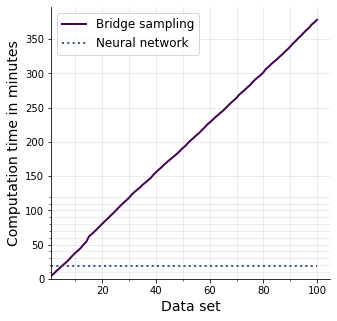

In [21]:
plot_computation_times(results_time_list, names=names, save=True)

In [22]:
# Get minimum number of datasets for which NNs are faster than bridge sampling

print(np.where(results_time_list[0] > results_time_list[1])[0][0]+1) # +1 as numpy uses 0-based indexing

5
